In [ ]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras import Sequential
from keras import regularizers
from keras import optimizers
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPooling2D,Dropout
from keras import callbacks
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
from IPython.display import Image
from keras.utils import plot_model

tf.random.set_seed(7)


# Preprocessing

In [ ]:
class_labels_blood={0: 'basophil', 1: 'eosinophil',2: 'erythroblast',3: 'immature granulocytes',4: 'lymphocyte',5: 'monocyte',6: 'neutrophil',7: 'platelet'}
def Load_data(npz_file_path):
  data_Bl=np.load(npz_file_path)

  #normalizing the data
  train_x= data_Bl['train_images']/255.0
  train_y= data_Bl['train_labels']
  test_x= data_Bl['test_images']/255.0
  test_y= data_Bl['test_labels']
  val_x= data_Bl['val_images']/255.0
  val_y= data_Bl['val_labels']

  print('Blood Dataset:')
  classes=np.unique(train_y)
  print('Classes: ',classes)
  imageShape=train_x[0].shape
  print('Input shape: ',imageShape)

  print('Null values in Train Blood dataset - ',np.isnan(train_x).any())
  print('Null values in Train Blood labels - ',np.isnan(train_y).any())
  print('Null values in Test Blood dataset - ',np.isnan(test_x).any())
  print('Null values in Test Blood labels - ',np.isnan(test_y).any())
  print('Null values in Validation Blood dataset - ',np.isnan(val_x).any())
  print('Null values in Validation Blood labels - ',np.isnan(val_y).any())

  return train_x,train_y,test_x,test_y,val_x,val_y, classes, imageShape

In [ ]:
def check_class_balance(Y_data)->(bool,dict):
    unique, counts = np.unique(Y_data,return_counts=True)
    label_dict=dict(zip(unique,counts))
    isTrue = True if label_dict[0] == label_dict[1] == label_dict[2] ==label_dict[3] ==label_dict[4] ==label_dict[5] ==label_dict[6] ==label_dict[7] else False
    return isTrue, label_dict

In [ ]:
def plot_ground_truth(train_x,train_y):
  y_blood= to_categorical(train_y)
  #mapping indices to labels
  class_labels_blood={0: 'basophil', 1: 'eosinophil',2: 'erythroblast',3: 'immature granulocytes',4: 'lymphocyte',5: 'monocyte',6: 'neutrophil',7: 'platelet'}
  indices_blood = np.random.choice(train_x.shape[0], size=15, replace=False)

  # Plot the images and corresponding class labels
  fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))
  for i, ax in enumerate(axes.flat):
    ax.imshow(train_x[indices_blood[i]], cmap='gray')
    ax.set_title(class_labels_blood[np.argmax(y_blood[indices_blood[i]])])
    ax.axis('off')
  plt.tight_layout()
  plt.show()


In [ ]:
def oversample_data(train_x,train_y,val_x,val_y):
  train_x_r=train_x.reshape(len(train_x),28*28*3)
  val_x_r=val_x.reshape(len(val_x),28*28*3)

  ros = RandomOverSampler(random_state=0)
  train_x_resampled, train_y_resampled = ros.fit_resample(train_x_r, train_y)
  val_x_resampled, val_y_resampled= ros.fit_resample(val_x_r,val_y)

  val_x_re=val_x_resampled.reshape(len(val_x_resampled),28,28,3)
  train_x_re=train_x_resampled.reshape(18640,28,28,3)

  return train_x_re,train_y_resampled,val_x_re,val_y_resampled


# Scoring Matrix

In [ ]:
def metrics(result,test_y,classes_y,class_name=('basophil','eosinophil','erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil','platelet'),avg='binary'):
  
  lb=preprocessing.LabelBinarizer()
  y_pred_prob=result
  y=np.rint(y_pred_prob)
  
  true_y=lb.fit_transform(test_y)
  y_true=lb.inverse_transform(true_y)
  
  y_pred=lb.inverse_transform(y)
  
  #print(y_true)
  #print(y)

  ## accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_true, y_pred)
  print('Accuracy: %.3f ' % (accuracy*100))

  ## precision tp / (tp + fp)
  precision = precision_score(y_true, y_pred,average=avg)
  print('Precision: %.3f ' % (precision*100))

  ## recall: tp / (tp + fn)
  recall = recall_score(y_true, y_pred,average=avg)
  print('Recall: %.3f ' % (recall*100))

  ## f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_true, y_pred,average=avg)
  print('F1 score: %.3f ' % (f1*100))

  ## ROC AUC
  auc = roc_auc_score(true_y, y_pred_prob)
  print('ROC AUC: %.3f' % auc)

  ## Confusion Matrix
  matrix= confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10,10),dpi=100)
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')
  plt.xlabel("Predicted value")
  plt.ylabel("True Values")
  



def plotLossAcc(history):
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  epoch_count = range(1, len(training_loss) + 1)

  plt.plot(epoch_count, training_loss, "r--")
  plt.plot(epoch_count, test_loss, "b--")
  plt.legend(["Training Loss", "Test Loss"])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  training_accuracy = history.history["accuracy"]
  test_accuracy = history.history["val_accuracy"]

  plt.plot(epoch_count, training_accuracy, "r--")
  plt.plot(epoch_count, test_accuracy, "b--")
  plt.legend(["Training Accuracy", "Test Accuracy"])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy Score")
  plt.show()

# DNN Model

In [ ]:
def create_model()-> keras.Model:
    model = Sequential()
    model.add(Conv2D(16,kernel_size=(2,2),padding='valid', activation='relu',input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding='valid'))

    model.add(Conv2D(32,kernel_size=(2,2),padding='valid', activation='relu',input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2,2),strides=1,padding='valid'))

    model.add(Conv2D(64,kernel_size=(2,2),padding='valid', activation='relu',input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

    model.add(Conv2D(128,kernel_size=(2,2),padding='valid', activation='relu',input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

    model.add(Conv2D(256,kernel_size=(2,2),padding='valid', activation='relu',input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='softmax',kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.05)))

    return model


In [ ]:
def compile_model(model:keras.Model)-> keras.Model:
  optm=optimizers.Adam(learning_rate=0.0005) #learning function setting

  model.compile(optimizer=optm,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
def train_model(model:keras.Model,train_x,train_y,val_x,val_y,classes):
  my_callbacks = [callbacks.EarlyStopping(patience=20)]
  history = model.fit(x=train_x, y=train_y, epochs=60, validation_data=(val_x, val_y),callbacks=my_callbacks, batch_size=40, verbose=1)
  plotLossAcc(history)
  evaluate_model(model,test_x,test_y,classes)

In [ ]:
def evaluate_model(model:keras.Model, test_x, test_y,classes):
  result1= model.predict(test_x,verbose=1)
  metrics(result1,test_y,classes,avg='weighted')

In [ ]:
def predict_model(model:keras.Model, ind,class_labels=class_labels_blood): #predicts model and gives prediction with the corresponding class names
    x=test_x[ind].reshape(-1,28,28,3)  # image obtained
    y=np.rint(model.predict(x))   #prediction obtained
    y_ch=int(max(y[0]*[0,1,2,3,4,5,6,7])) #labeling the prediction
    
    print("predicted class: " + str(y_ch))
    print("actual class: " + str(test_y[ind][0]))
    print("Class name: "+ class_labels[y_ch])    # class predicted

# Pretrain DNN Model

In [ ]:
def IN1_model()-> keras.Model:
    rn='https://tfhub.dev/google/imagenet/inception_v1/classification/5'
    IN1 = tf.keras.Sequential([hub.KerasLayer(rn,input_shape=(28,28,3), trainable=False)])
    IN1.add(Flatten())
    IN1.add(Dense(512,activation='relu'))
    IN1.add(Dropout(0.4))
    IN1.add(Dense(128,activation='relu'))
    IN1.add(Dense(64,activation='relu'))
    IN1.add(Dense(8,activation='softmax',kernel_regularizer=regularizers.L1L2(l1=0.0001 ,l2=0.05)))
    IN1.summary()

    return IN1

def compile_IN1(IN1:keras.Model)->keras.Model:
    optm=keras.optimizers.Adam(learning_rate=0.001)
    IN1.compile(optimizer=optm,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return IN1

def IN1_train(IN1:keras.Model,train_x,train_y,val_x,val_y,classes):
    history = IN1.fit(x=train_x, y=train_y, epochs=100, validation_data=(val_x, val_y), batch_size=30, verbose=1)
    plotLossAcc(history)
    evaluate_IN1(IN1,test_x,test_y,classes)

def evaluate_IN1(IN1:keras.Model, test_x, test_y,classes):
    results= IN1.predict(test_x,verbose=1)
    metrics(results,test_y,classes,avg='weighted')


#####################################################################################################
def RES50_model()-> keras.Model:
    rn='https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5'
    Res50 = tf.keras.Sequential([hub.KerasLayer(rn,input_shape=(28,28,3),trainable=False)])
    Res50.add(Flatten())
    Res50.add(Dense(512,activation='relu'))
    Res50.add(Dropout(0.4))
    Res50.add(Dense(256,activation='relu'))
    Res50.add(Dense(128,activation='relu'))
    Res50.add(Dense(64,activation='relu'))
    Res50.add(Dense(8,activation='softmax',kernel_regularizer=regularizers.L1L2(l1=0.0001 ,l2=0.05)))

    return Res50

def compile_RES50(Res50:keras.Model)->keras.Model:
    optm=keras.optimizers.Adam(learning_rate=0.001)
    Res50.compile(optimizer=optm,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return Res50

def RES50_train(Res50:keras.Model,train_x,train_y,val_x,val_y,classes):
    history = Res50.fit(x=train_x, y=train_y, epochs=70, validation_data=(val_x, val_y), batch_size=30, verbose=1)
    plotLossAcc(history)
    evaluate_Res50(Res50,test_x,test_y,classes)

def evaluate_Res50(Res50:keras.Model, test_x, test_y,classes):
    results= Res50.predict(test_x,verbose=1)
    metrics(results,test_y,classes,avg='weighted')


#########################################################################################################################

def EFlite3_model()-> keras.Model:
    rn='https://tfhub.dev/tensorflow/efficientnet/lite3/classification/2'
    EFlite3 = tf.keras.Sequential([hub.KerasLayer(rn,input_shape=(28,28,3), trainable=False)])
    EFlite3.add(Flatten())
    EFlite3.add(Dense(256,activation='relu'))
    EFlite3.add(Dropout(0.4))
    EFlite3.add(Dense(128,activation='relu'))
    EFlite3.add(Dense(64,activation='relu'))
    EFlite3.add(Dense(8,activation='softmax',kernel_regularizer=regularizers.L1L2(l1=0.0001 ,l2=0.05)))
    EFlite3.summary()

    return EFlite3

def compile_EFlite3(EFlite3:keras.Model)->keras.Model:
    optm=keras.optimizers.Adam(learning_rate=0.001)
    EFlite3.compile(optimizer=optm,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return EFlite3

def EFlite3_train(EFlite3:keras.Model,train_x,train_y,val_x,val_y,classes):
    history = EFlite3.fit(x=train_x, y=train_y, epochs=70, validation_data=(val_x, val_y), batch_size=30, verbose=1)
    plotLossAcc(history)
    evaluate_EFlite3(EFlite3,test_x,test_y,classes)

def evaluate_EFlite3(EFlite3:keras.Model, test_x, test_y,classes):
    results= EFlite3.predict(test_x,verbose=1)
    metrics(results,test_y,classes,avg='weighted')



#########################################################################################################################

def EFLite_model()-> keras.Model:
    rn='https://tfhub.dev/tensorflow/efficientnet/lite0/classification/2'
    EFLite = tf.keras.Sequential([hub.KerasLayer(rn,input_shape=(28,28,3), trainable=False)])
    EFLite.add(Flatten())
    EFLite.add(Dense(128,activation='relu'))
    EFLite.add(Dropout(0.4))
    EFLite.add(Dense(64,activation='relu'))
    EFLite.add(Dense(8,activation='softmax',kernel_regularizer=regularizers.L1L2(l1=0.0001 ,l2=0.005)))
    EFLite.summary()


    return EFLite

def compile_EFLite(EFLite:keras.Model)->keras.Model:
    optm=keras.optimizers.Adam(learning_rate=0.001)
    EFLite.compile(optimizer=optm,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return EFLite

def EFLite_train(EFLite:keras.Model,train_x,train_y,val_x,val_y,classes):
    history = EFLite.fit(x=train_x, y=train_y, epochs=70, validation_data=(val_x, val_y), batch_size=30, verbose=1)
    plotLossAcc(history)
    evaluate_EFLite(EFLite,test_x,test_y,classes)

def evaluate_EFLite(EFLite:keras.Model, test_x, test_y,classes):
    results= EFLite.predict(test_x,verbose=1)
    metrics(results,test_y,classes,avg='weighted')


Blood Dataset:
Classes:  [0 1 2 3 4 5 6 7]
Input shape:  (28, 28, 3)
Null values in Train Blood dataset -  False
Null values in Train Blood labels -  False
Null values in Test Blood dataset -  False
Null values in Test Blood labels -  False
Null values in Validation Blood dataset -  False
Null values in Validation Blood labels -  False


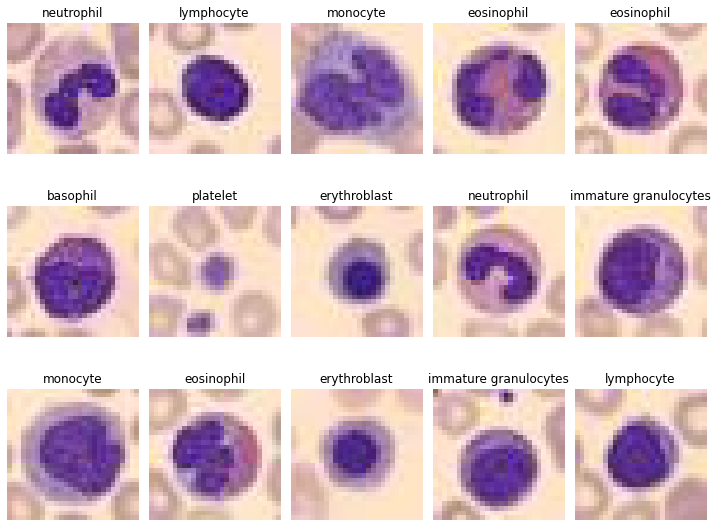

In [ ]:
#Load data and check ground truth
train_x,train_y,test_x,test_y,val_x,val_y,classes, imageShape= Load_data('bloodmnist.npz')
class_labels_blood={0: 'basophil', 1: 'eosinophil',2: 'erythroblast',3: 'immature granulocytes',4: 'lymphocyte',5: 'monocyte',6: 'neutrophil',7: 'platelet'}
plot_ground_truth(train_x,train_y)

In [ ]:
#checking for balance and class types
bal_t, uniq_t= check_class_balance(train_y)
print("Is train data classes balanced : %s" % bal_t)
print(uniq_t)
bal_v, uniq_v= check_class_balance(val_y)
print("Is val data classes balanced : %s" % bal_v)
print(uniq_v)

#oversampling to balance the samples
train_xr,train_yr,val_xr,val_yr=oversample_data(train_x,train_y,val_x,val_y)

print("After sampling data: ")
bal_t, uniq_t= check_class_balance(train_yr)
print("Is train data classes balanced : %s" % bal_t)
print(uniq_t)
bal_v, uniq_v= check_class_balance(val_yr)
print("Is val data classes balanced : %s" % bal_v)
print(uniq_v)

Is train data classes balanced : False
{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}
Is val data classes balanced : False
{0: 122, 1: 312, 2: 155, 3: 290, 4: 122, 5: 143, 6: 333, 7: 235}
After sampling data: 
Is train data classes balanced : True
{0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}
Is val data classes balanced : True
{0: 333, 1: 333, 2: 333, 3: 333, 4: 333, 5: 333, 6: 333, 7: 333}


## Created Model

### Model without RandomOverSampling

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 27, 27, 16)        208       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 23, 23, 64)        8256      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 11, 11, 64)      

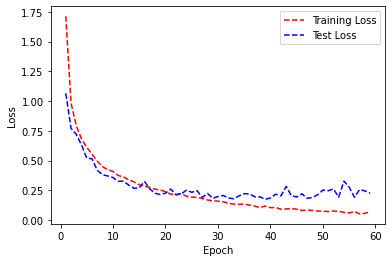

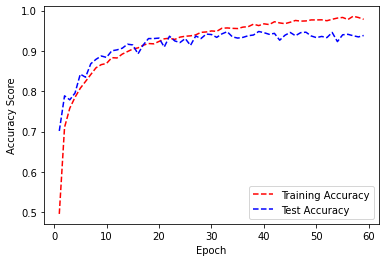

107/107 [==============================] - 0s 3ms/step
Accuracy: 92.458 
Precision: 92.739 
Recall: 92.458 
F1 score: 92.425 
ROC AUC: 0.995


<ipython-input-91-10d4514ed58b>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')


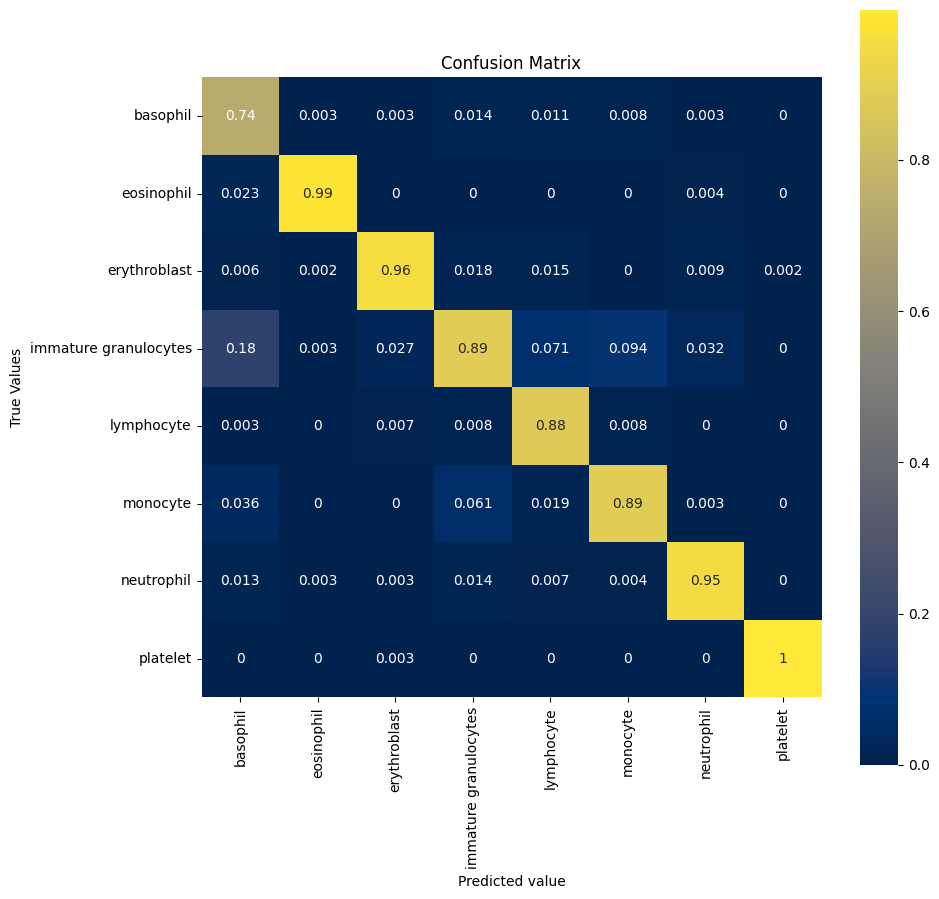

In [ ]:
#create CNN
model_base=create_model()
model_base.summary()

#compile and evaluate CNN
model_base=compile_model(model_base)
train_model(model_base,train_x,train_y,val_x,val_y,classes)#after training the performance metrics is printed out


### Model with RandomOverSampling

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0

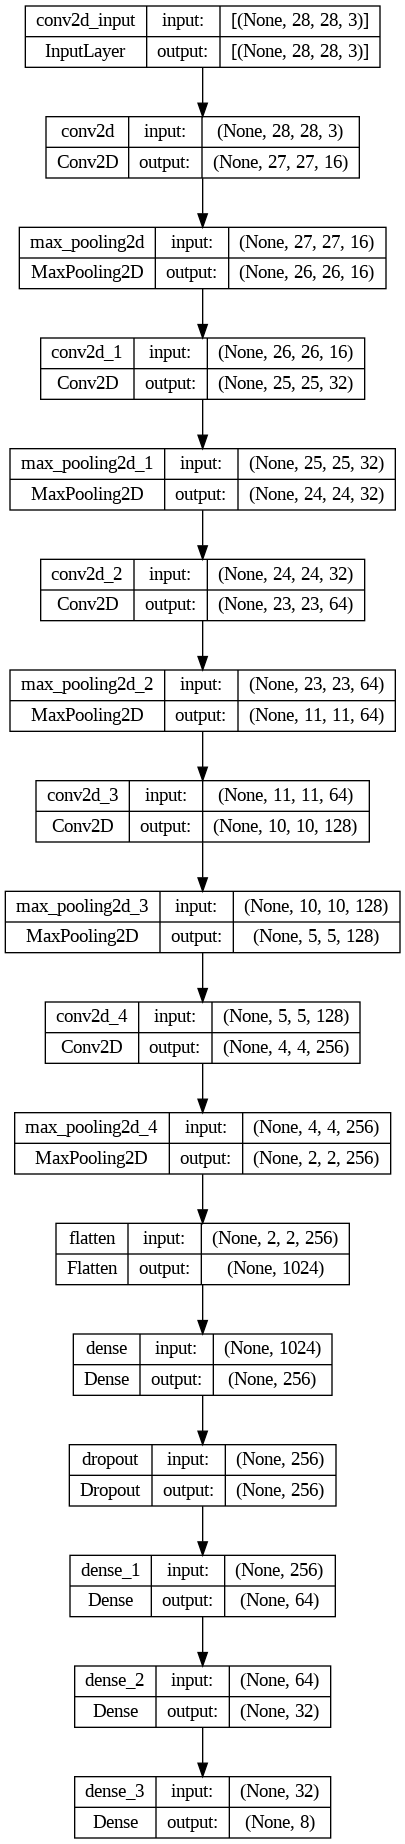

In [ ]:
#create CNN
model=create_model()
model.summary()

#visualising model architecture
plot_model(model,to_file='model.png',show_shapes=True)
Image('model.png')

Epoch 1/60
466/466 [==============================] - 13s 6ms/step - loss: 1.5866 - accuracy: 0.5179 - val_loss: 1.0002 - val_accuracy: 0.7035
Epoch 2/60
466/466 [==============================] - 3s 5ms/step - loss: 0.9191 - accuracy: 0.7214 - val_loss: 0.6822 - val_accuracy: 0.7988
Epoch 3/60
466/466 [==============================] - 3s 6ms/step - loss: 0.7051 - accuracy: 0.7892 - val_loss: 0.5411 - val_accuracy: 0.8457
Epoch 4/60
466/466 [==============================] - 3s 6ms/step - loss: 0.5953 - accuracy: 0.8173 - val_loss: 0.4840 - val_accuracy: 0.8559
Epoch 5/60
466/466 [==============================] - 3s 6ms/step - loss: 0.5103 - accuracy: 0.8410 - val_loss: 0.4097 - val_accuracy: 0.8926
Epoch 6/60
466/466 [==============================] - 3s 5ms/step - loss: 0.4543 - accuracy: 0.8586 - val_loss: 0.4439 - val_accuracy: 0.8626
Epoch 7/60
466/466 [==============================] - 3s 6ms/step - loss: 0.4014 - accuracy: 0.8775 - val_loss: 0.3617 - val_accuracy: 0.8896
Epoch

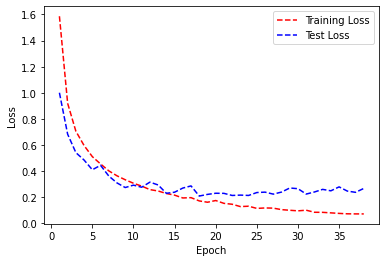

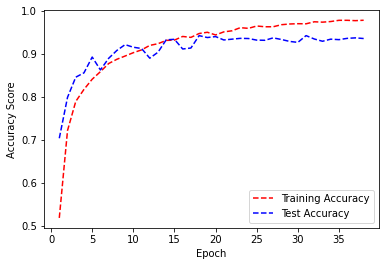

107/107 [==============================] - 1s 3ms/step
Accuracy: 92.488 
Precision: 92.874 
Recall: 92.488 
F1 score: 92.510 
ROC AUC: 0.995


<ipython-input-6-10d4514ed58b>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')


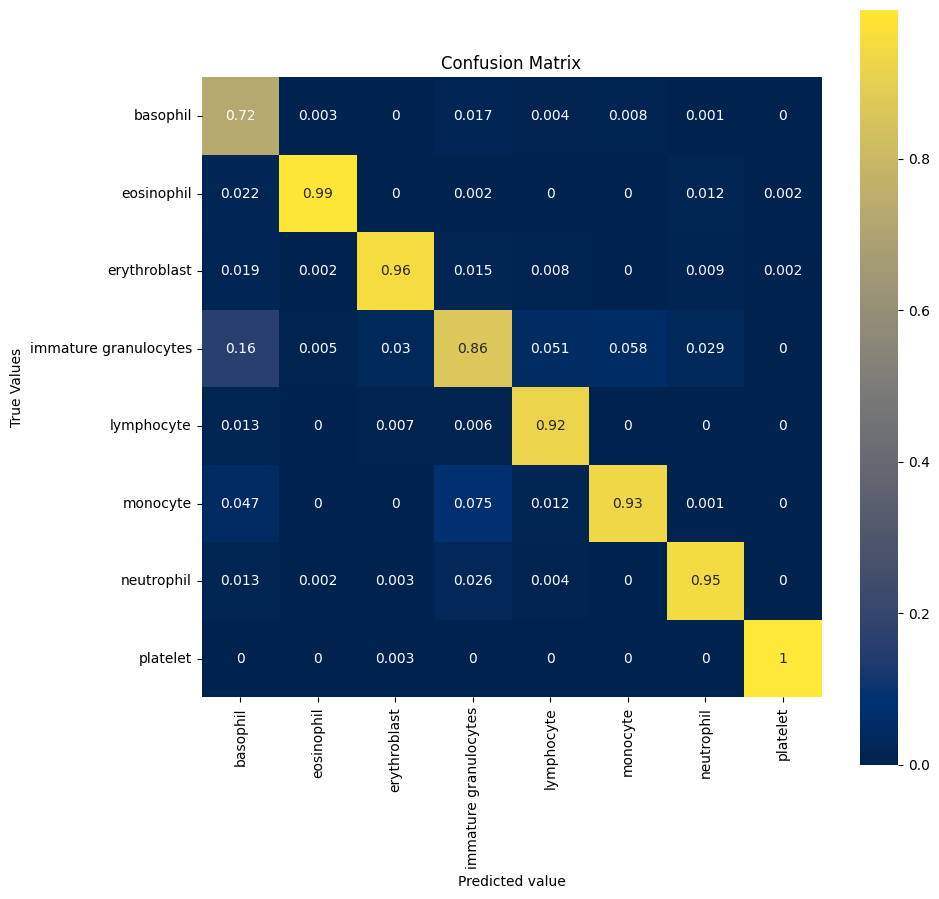

In [ ]:
#compile and evaluate CNN
model=compile_model(model)
train_model(model,train_xr,train_yr,val_xr,val_yr,classes)#after training the performance metrics is printed out

In [ ]:
ind=154 #changing the number here gives class prediction by the model of that sample number in the test dataset
predict_model(model,ind)

1/1 [==============================] - 0s 46ms/step
predicted class: 0
actual class: 0
Class name: basophil


Saving the Trained model to file

In [ ]:
!mkdir -p saved_model_final
model.save('saved_model_final/blood_novel_model')



Pretrain DNN

## Inception V1

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              6633209   
                                                                 
 flatten_9 (Flatten)         (None, 1001)              0         
                                                                 
 dense_35 (Dense)            (None, 512)               513024    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               65664     
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 8)                

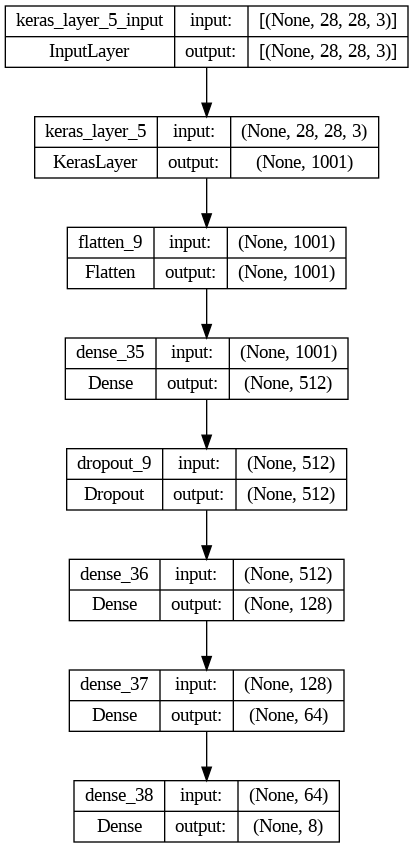

In [ ]:
#inception v1
in1=IN1_model()
in1.summary()

plot_model(in1,to_file='IN1.png',show_shapes=True)
Image('IN1.png')

Epoch 1/100
622/622 [==============================] - 12s 12ms/step - loss: 1.3734 - accuracy: 0.5809 - val_loss: 0.9843 - val_accuracy: 0.6577
Epoch 2/100
622/622 [==============================] - 8s 13ms/step - loss: 0.9545 - accuracy: 0.6647 - val_loss: 0.8656 - val_accuracy: 0.7050
Epoch 3/100
622/622 [==============================] - 6s 10ms/step - loss: 0.8655 - accuracy: 0.6915 - val_loss: 0.8330 - val_accuracy: 0.7132
Epoch 4/100
622/622 [==============================] - 7s 12ms/step - loss: 0.8143 - accuracy: 0.7049 - val_loss: 0.8170 - val_accuracy: 0.7065
Epoch 5/100
622/622 [==============================] - 7s 11ms/step - loss: 0.7792 - accuracy: 0.7197 - val_loss: 0.7801 - val_accuracy: 0.7177
Epoch 6/100
622/622 [==============================] - 8s 12ms/step - loss: 0.7590 - accuracy: 0.7254 - val_loss: 0.7820 - val_accuracy: 0.7294
Epoch 7/100
622/622 [==============================] - 7s 11ms/step - loss: 0.7215 - accuracy: 0.7392 - val_loss: 0.7667 - val_accuracy

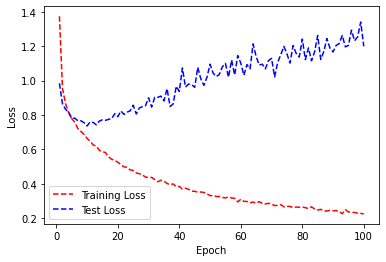

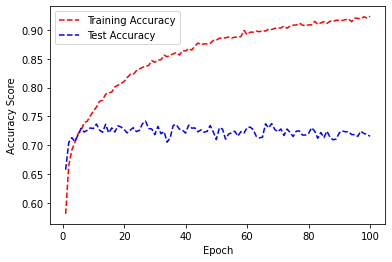

107/107 [==============================] - 2s 9ms/step
Accuracy: 73.458 
Precision: 75.150 
Recall: 73.458 
F1 score: 73.834 
ROC AUC: 0.948


<ipython-input-91-10d4514ed58b>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')


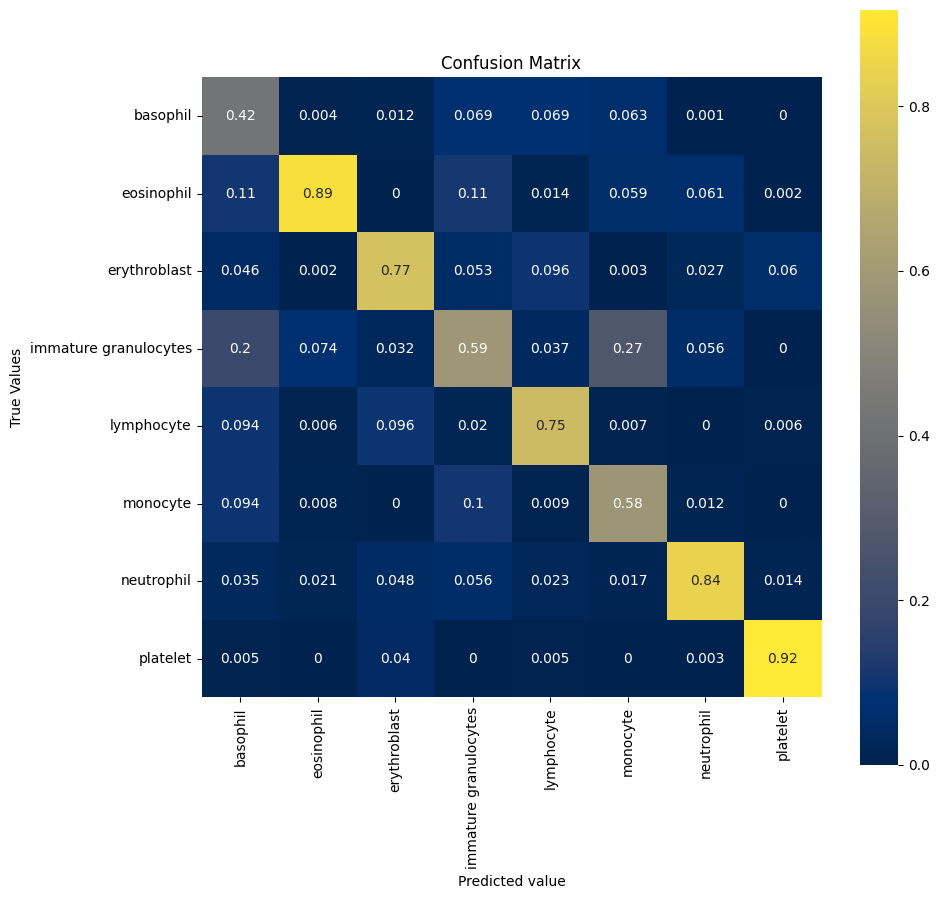

In [ ]:

#compile and evaluate CNN
in1=compile_IN1(in1)
IN1_train(in1,train_xr,train_yr,val_xr,val_yr,classes)

In [ ]:
ind=1024
predict_model(in1,ind)

1/1 [==============================] - 0s 108ms/step
predicted class: 1
actual class: 1
Class name: eosinophil


## ResNet 50

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25612201  
                                                                 
 flatten_1 (Flatten)         (None, 1001)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               513024    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)               

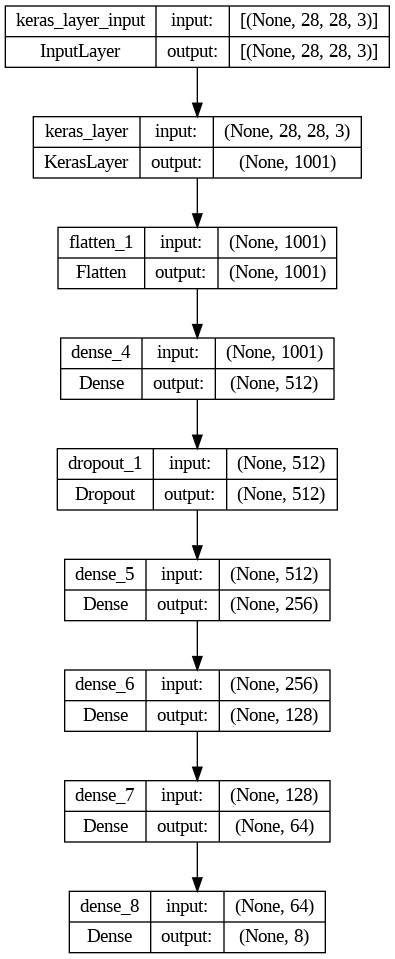

In [ ]:
#ResNet 50
res50=RES50_model()
res50.summary()

plot_model(res50,to_file='RES50.png',show_shapes=True)
Image('RES50.png')

Epoch 1/70
622/622 [==============================] - 19s 19ms/step - loss: 1.3955 - accuracy: 0.5901 - val_loss: 0.9588 - val_accuracy: 0.6802
Epoch 2/70
622/622 [==============================] - 8s 13ms/step - loss: 0.9814 - accuracy: 0.6630 - val_loss: 0.8583 - val_accuracy: 0.7031
Epoch 3/70
622/622 [==============================] - 8s 14ms/step - loss: 0.9004 - accuracy: 0.6818 - val_loss: 0.7901 - val_accuracy: 0.7218
Epoch 4/70
622/622 [==============================] - 8s 14ms/step - loss: 0.8590 - accuracy: 0.6918 - val_loss: 0.7825 - val_accuracy: 0.7215
Epoch 5/70
622/622 [==============================] - 8s 13ms/step - loss: 0.8251 - accuracy: 0.7069 - val_loss: 0.7786 - val_accuracy: 0.7245
Epoch 6/70
622/622 [==============================] - 8s 13ms/step - loss: 0.8083 - accuracy: 0.7111 - val_loss: 0.7730 - val_accuracy: 0.7110
Epoch 7/70
622/622 [==============================] - 8s 13ms/step - loss: 0.7890 - accuracy: 0.7160 - val_loss: 0.7364 - val_accuracy: 0.732

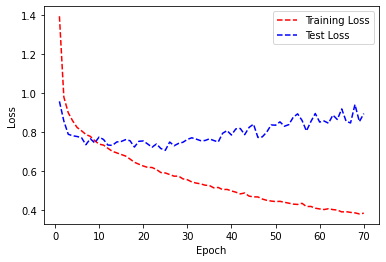

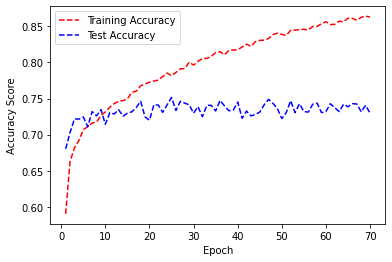

107/107 [==============================] - 3s 15ms/step
Accuracy: 69.424 
Precision: 74.763 
Recall: 69.424 
F1 score: 70.796 
ROC AUC: 0.946


<ipython-input-6-10d4514ed58b>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')


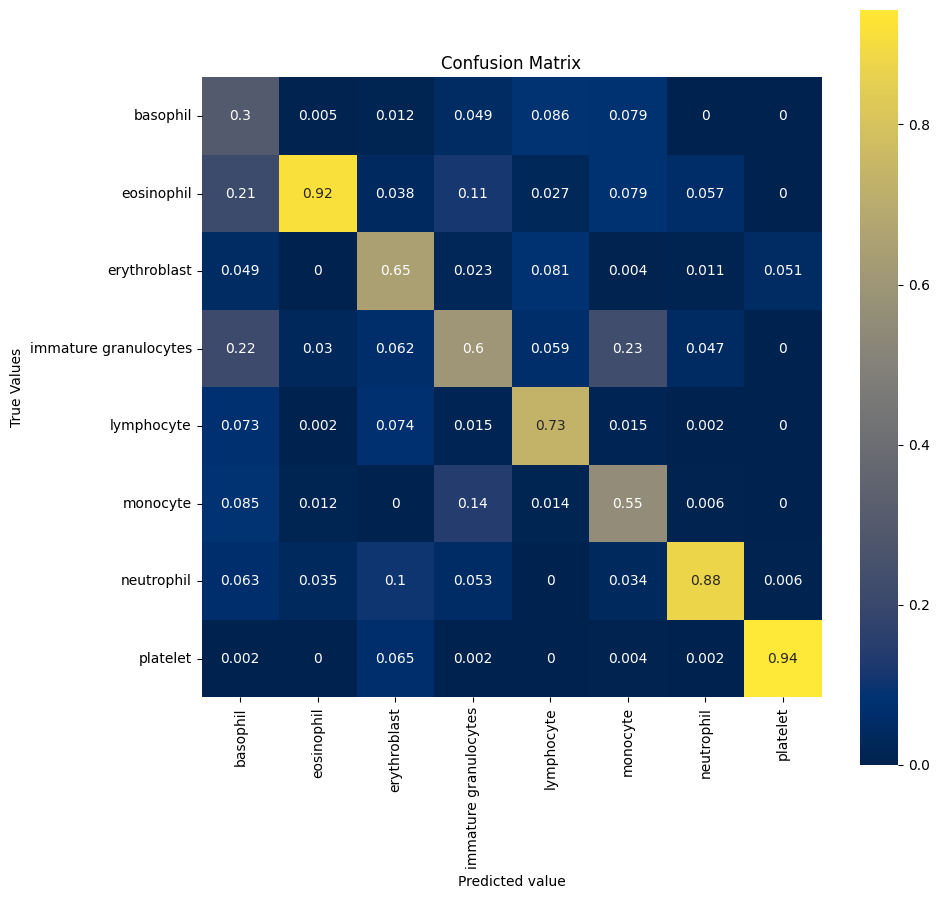

In [ ]:
#compile and evaluate CNN
res50=compile_RES50(res50)
RES50_train(res50,train_xr,train_yr,val_xr,val_yr,classes)

In [ ]:
ind=8
predict_model(res50,ind)

1/1 [==============================] - 0s 38ms/step
predicted class: 6
actual class: 6
Class name: neutrophil


## Efficient lite3

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1000)              8273768   
                                                                 
 flatten_12 (Flatten)        (None, 1000)              0         
                                                                 
 dense_47 (Dense)            (None, 256)               256256    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_48 (Dense)            (None, 128)               32896     
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 dense_50 (Dense)            (None, 8)               

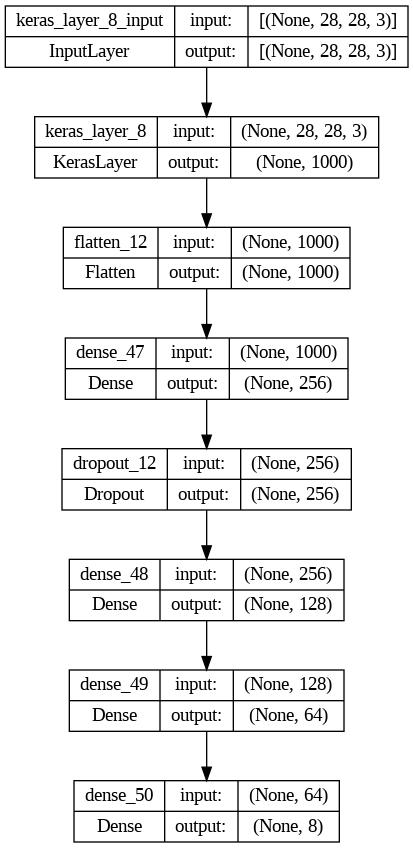

In [ ]:
#efficientnet/b3
efl3=EFlite3_model()
efl3.summary()

plot_model(efl3,to_file='EFlite3.png',show_shapes=True)
Image('EFlite3.png')

Epoch 1/70
622/622 [==============================] - 13s 15ms/step - loss: 1.8981 - accuracy: 0.3153 - val_loss: 1.6636 - val_accuracy: 0.3863
Epoch 2/70
622/622 [==============================] - 8s 14ms/step - loss: 1.6732 - accuracy: 0.3636 - val_loss: 1.6150 - val_accuracy: 0.3968
Epoch 3/70
622/622 [==============================] - 8s 12ms/step - loss: 1.6335 - accuracy: 0.3766 - val_loss: 1.6024 - val_accuracy: 0.3919
Epoch 4/70
622/622 [==============================] - 8s 13ms/step - loss: 1.6153 - accuracy: 0.3790 - val_loss: 1.5692 - val_accuracy: 0.4137
Epoch 5/70
622/622 [==============================] - 8s 13ms/step - loss: 1.6046 - accuracy: 0.3881 - val_loss: 1.5747 - val_accuracy: 0.4215
Epoch 6/70
622/622 [==============================] - 7s 11ms/step - loss: 1.5990 - accuracy: 0.3857 - val_loss: 1.5579 - val_accuracy: 0.4152
Epoch 7/70
622/622 [==============================] - 8s 13ms/step - loss: 1.5865 - accuracy: 0.3891 - val_loss: 1.5652 - val_accuracy: 0.422

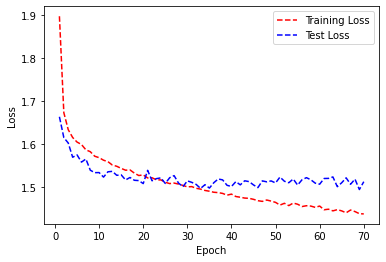

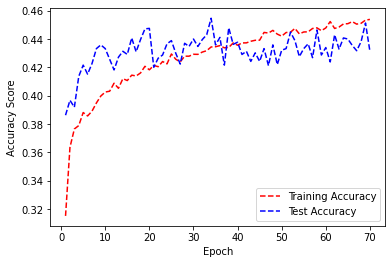

107/107 [==============================] - 2s 9ms/step
Accuracy: 24.525 
Precision: 60.557 
Recall: 24.525 
F1 score: 27.280 
ROC AUC: 0.820


<ipython-input-91-10d4514ed58b>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')


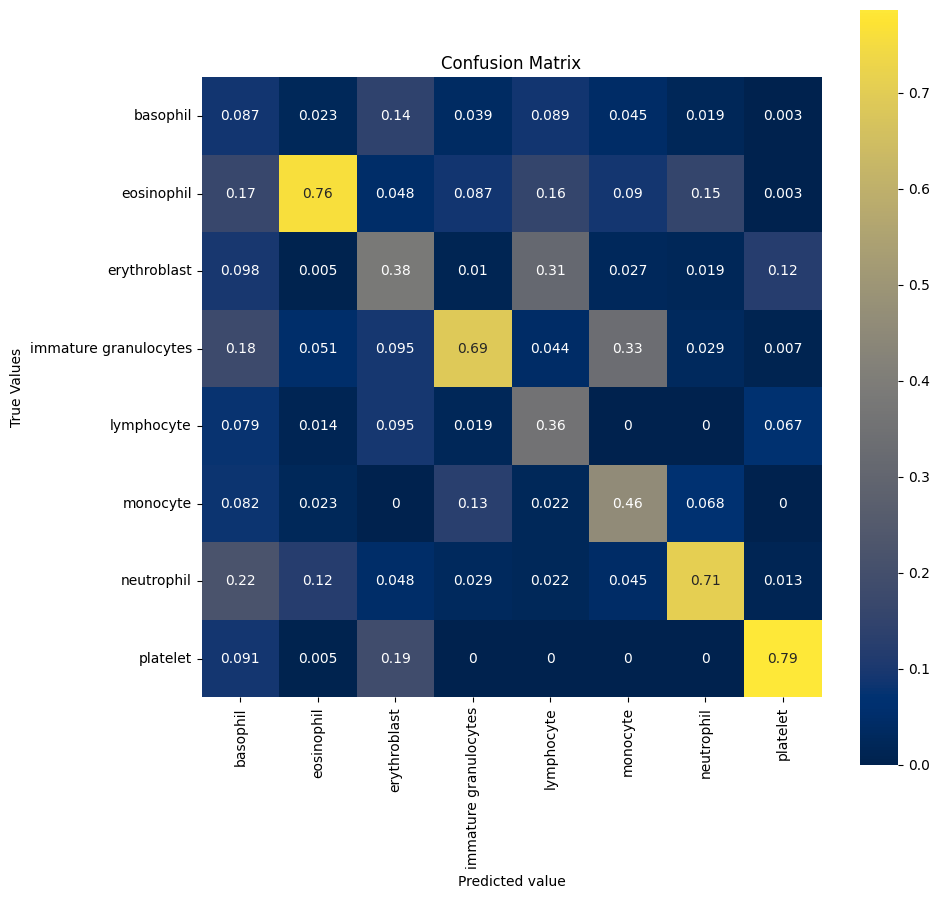

In [ ]:

#compile and evaluate CNN
efl3=compile_EFlite3(efl3)
EFlite3_train(efl3,train_xr,train_yr,val_xr,val_yr,classes)

In [ ]:
ind=1024
predict_model(efl3,ind)

1/1 [==============================] - 0s 99ms/step
predicted class: 0
actual class: 1
Class name: basophil


## Efficientnet lite 0

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 1000)              4694024   
                                                                 
 flatten_13 (Flatten)        (None, 1000)              0         
                                                                 
 dense_51 (Dense)            (None, 128)               128128    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 8)                 520       
                                                                 
Total params: 4,830,928
Trainable params: 136,904
Non

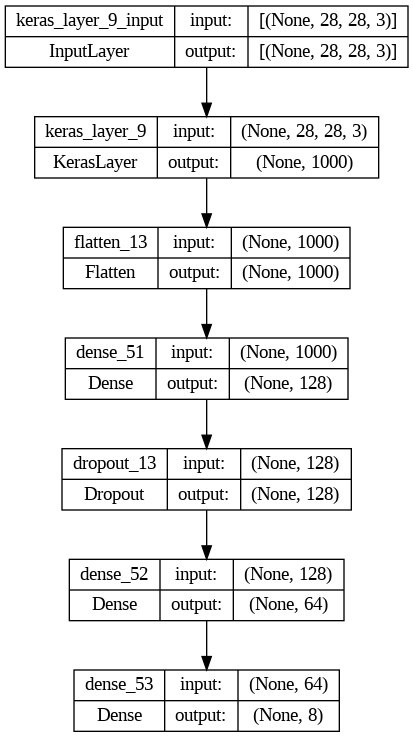

In [ ]:
# efficientnet/lite0
eflite=EFLite_model()
eflite.summary()
plot_model(eflite,to_file='EFLITE.png',show_shapes=True)
Image('EFLITE.png')

Epoch 1/70
622/622 [==============================] - 9s 10ms/step - loss: 1.0816 - accuracy: 0.6160 - val_loss: 0.8804 - val_accuracy: 0.6869
Epoch 2/70
622/622 [==============================] - 6s 10ms/step - loss: 0.8927 - accuracy: 0.6790 - val_loss: 0.8212 - val_accuracy: 0.7065
Epoch 3/70
622/622 [==============================] - 6s 9ms/step - loss: 0.8416 - accuracy: 0.6946 - val_loss: 0.8346 - val_accuracy: 0.6959
Epoch 4/70
622/622 [==============================] - 6s 10ms/step - loss: 0.8024 - accuracy: 0.7016 - val_loss: 0.7893 - val_accuracy: 0.7065
Epoch 5/70
622/622 [==============================] - 6s 9ms/step - loss: 0.7728 - accuracy: 0.7204 - val_loss: 0.7632 - val_accuracy: 0.7207
Epoch 6/70
622/622 [==============================] - 6s 10ms/step - loss: 0.7556 - accuracy: 0.7218 - val_loss: 0.7591 - val_accuracy: 0.7260
Epoch 7/70
622/622 [==============================] - 6s 9ms/step - loss: 0.7420 - accuracy: 0.7234 - val_loss: 0.7450 - val_accuracy: 0.7339
Ep

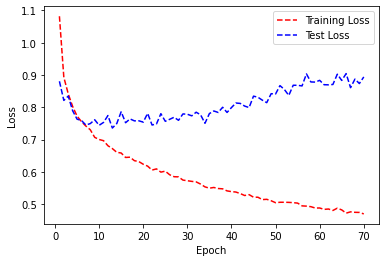

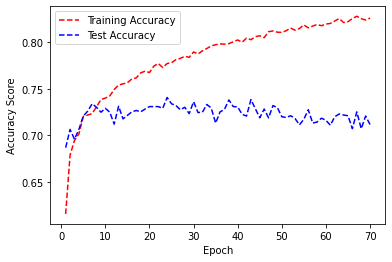

107/107 [==============================] - 1s 7ms/step
Accuracy: 71.383 
Precision: 74.850 
Recall: 71.383 
F1 score: 71.988 
ROC AUC: 0.951


<ipython-input-91-10d4514ed58b>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.round(matrix/matrix.astype(np.float).sum(axis=0),3),annot=True,square=True,xticklabels=class_name,yticklabels=class_name,cmap="cividis").set_title('Confusion Matrix')


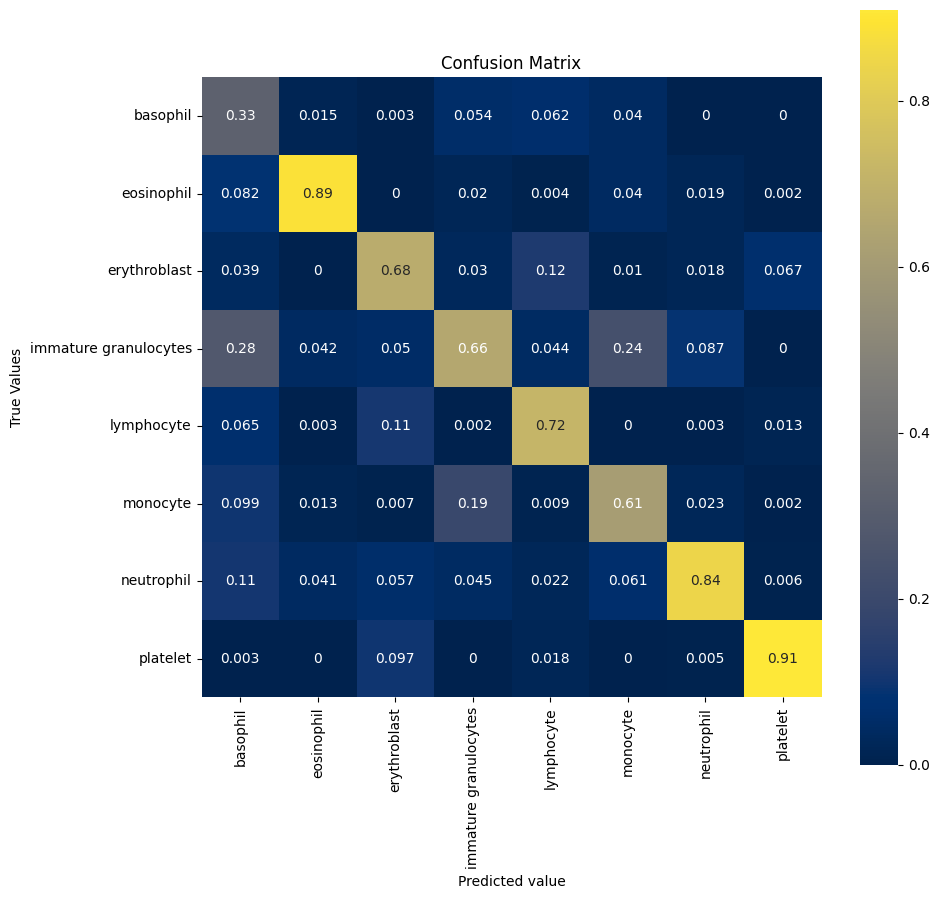

In [ ]:

#compile and evaluate CNN
eflite=compile_EFLite(eflite)
EFLite_train(eflite,train_xr,train_yr,val_xr,val_yr,classes)

In [ ]:
ind=1024
predict_model(eflite,ind)

1/1 [==============================] - 0s 43ms/step
predicted class: 1
actual class: 1
Class name: eosinophil


# Best pretrain-model saved


In [ ]:
res50.save('saved_model_final/blood_pre_train_model')
!zip -r /content/saved_model_final /content/saved_model_final

  adding: content/saved_model_final/ (stored 0%)
  adding: content/saved_model_final/blood_novel_model/ (stored 0%)
  adding: content/saved_model_final/blood_novel_model/variables/ (stored 0%)
  adding: content/saved_model_final/blood_novel_model/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: content/saved_model_final/blood_novel_model/variables/variables.index (deflated 70%)
  adding: content/saved_model_final/blood_novel_model/assets/ (stored 0%)
  adding: content/saved_model_final/blood_novel_model/fingerprint.pb (stored 0%)
  adding: content/saved_model_final/blood_novel_model/keras_metadata.pb (deflated 94%)
  adding: content/saved_model_final/blood_novel_model/saved_model.pb (deflated 89%)
  adding: content/saved_model_final/blood_pre_train_model/ (stored 0%)
  adding: content/saved_model_final/blood_pre_train_model/variables/ (stored 0%)
  adding: content/saved_model_final/blood_pre_train_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: con

In [ ]:
from google.colab import files
files.download('/content/saved_model_final')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Reference 
Boesch, G. (2023) Deep Residual Networks (ResNet, ResNet50) – 2023 Guide. [Online] 
Available at: https://viso.ai/deep-learning/resnet-residual-neural-network/#:~:text=Deep%20residual%20networks%20like%20the,other%20to%20form%20a%20network.
[Accessed 10 February 2023].

Brital, A. (2021) Inception V3 CNN Architecture Explained. [Online] 
Available at: https://medium.com/@AnasBrital98/inception-v3-cnn-architecture-explained-691cfb7bba08
[Accessed 10 March 2023].

Brownlee, J. (2016) Use Keras Deep Learning Models with Scikit-Learn in Python. [Online] 
Available at: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/
[Accessed 8 March 2023].

Brownlee, J. (2022) How to Calculate Precision, Recall, F1, and More for Deep Learning Models. [Online] 
Available at: https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
[Accessed 3 March 2023].

Foo, F. (2014) How to normalize a confusion matrix?. [Online] 
Available at: https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
[Accessed 15 March 2023].

Google (N/A) imagenet/inception_v1/classification. [Online] 
Available at: https://tfhub.dev/google/imagenet/inception_v1/classification/5
[Accessed 12 March 2023].

Google (N/A) imagenet/resnet_v1_50/classification. [Online] 
Available at: https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5
[Accessed 10 March 2023].

Hoorn, R. v. (2022) Ways to Reduce False Positive or False Negatives in Binary Classification (0,1). [Online] 
Available at: https://ai.stackexchange.com/questions/38405/ways-to-reduce-false-positive-or-false-negatives-in-binary-classification-0-1
[Accessed 10 March 2023].

Hugging Face (N/A) google/efficientnet-b3. [Online] 
Available at: https://huggingface.co/google/efficientnet-b3
[Accessed 10 March 2023].

Imbalance-learn (N/A) imblearn.over_sampling.RandomOverSampler. [Online] 
Available at: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html
[Accessed 25 February 2023].

Ji, Q., Huang, J., He, W. & Sun, Y. (2019) Optimized Deep Convolutional Neural Networks for Identification of Macular Diseases from Optical Coherence Tomography Images. [Online] 
Available at: https://www.researchgate.net/publication/331364877_Optimized_Deep_Convolutional_Neural_Networks_for_Identification_of_Macular_Diseases_from_Optical_Coherence_Tomography_Images
[Accessed 16 March 2023].

Keras (N/A) Adam. [Online] 
Available at: https://keras.io/api/optimizers/adam/
[Accessed 26 February 2023].

Keras (N/A) https://keras.io/api/applications/xception/. [Online] 
Available at: https://keras.io/api/applications/xception/
[Accessed 27 February 2023].

Keras (N/A) Layer weight regularizers. [Online] 
Available at: https://keras.io/api/layers/regularizers/
[Accessed 27 February 2023].

Koech, K. E. (2020) Cross-Entropy Loss Function. [Online] 
Available at: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e#:~:text=Categorical%20cross%2Dentropy%20is%20used,%5D%20for%203%2Dclass%20problem
[Accessed 25 February 2023].

Korstanje, J. (2021) The F1 score. [Online] 
Available at: https://towardsdatascience.com/the-f1-score-bec2bbc38aa6
[Accessed 15 March 2023].

Kumar, V. & jeffhale (2018) Inverse Process of Label Binarisation in Python. [Online] 
Available at: https://stackoverflow.com/questions/45118093/inverse-process-of-label-binarisation-in-python
[Accessed 15 March 2023].

Liang, X. (N/A) Machine Learning and Artificial Intelligence. [Online] 
Available at: https://kingston.app.box.com/s/9us9iwuz2nqm1fpgyf8oyy06zo81y263
[Accessed 5 February 2023].

machine-learning (2022) Inception-V1 (GoogLeNet): Summary and Implementation. [Online] 
Available at: https://hackmd.io/@machine-learning/Bk-61Fo8U
[Accessed 14 March 2023].

Narkhede, S. (2018) Understanding AUC - ROC Curve. [Online] 
Available at: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
[Accessed 15 March 2023].

NumPy (N/A) Array creation routines. [Online] 
Available at: https://numpy.org/doc/stable/reference/routines.array-creation.html
[Accessed 10 March 2023].

Rana, A. (2019) Scikit-learn's LabelBinarizer vs. OneHotEncoder. [Online] 
Available at: https://stackoverflow.com/questions/50473381/scikit-learns-labelbinarizer-vs-onehotencoder#:~:text=Scikitlearn%20suggests%20using%20OneHotEncoder%20for%20X%20matrix%20i.e.,you%20won%27t%20really%20need%20that%20in%20y%20labels
[Accessed 10 March 2023].

Sachan, A. (N/A) Detailed Guide to Understand and Implement ResNets. [Online] 
Available at: https://cv-tricks.com/keras/understand-implement-resnets/
[Accessed 10 March 2023].

Scikit Learn (N/A) sklearn.metrics.multilabel_confusion_matrix. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
[Accessed 5 March 2023].

Scikit Learn (N/A) sklearn.preprocessing.label_binarize. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html
[Accessed 3 March 2023].

Seaborn (N/A) seaborn.heatmap. [Online] 
Available at: https://seaborn.pydata.org/generated/seaborn.heatmap.html
[Accessed 15 March 2023].

Tang, L. (2021) Draw Confusion Matrix for CNN models. [Online] 
Available at: https://leslietj.github.io/2020/06/22/Draw-Confusion-Matrix-for-CNN-models/
[Accessed 15 March 2023].

T, D. (2019) Confusion Matrix Visualization. [Online] 
Available at: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
[Accessed 28 February 2023].

Tensorflow (N/A) efficientnet/b3/classification. [Online] 
Available at: https://tfhub.dev/tensorflow/efficientnet/b3/classification/1
[Accessed 12 March 2023].

Tensorflow (N/A) efficientnet/lite0/classification. [Online] 
Available at: https://tfhub.dev/tensorflow/efficientnet/lite0/classification/2
[Accessed 12 March 2023].

Tensorflow (N/A) efficientnet/lite3/classification. [Online] 
Available at: https://tfhub.dev/tensorflow/efficientnet/lite3/classification/2
[Accessed 12 March 2023].

University of Michigan Library (2022) All About Images. [Online] 
Available at: https://guides.lib.umich.edu/c.php?g=282942&p=1885347#:~:text=Not%20all%20of%20our%20images%20are%20the%20exact,will%20be%20discarded%20by%20the%20photo%20editor%20%28Photoshop%29
[Accessed 16 March 2023].

Verma, S.(2019) A Simple Guide to Using Keras Pretrained Models. [Online] 
Available at: https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
[Accessed 1 March 2023].

Yalçın, O. G.(2018) Image Classification in 10 Minutes with MNIST Dataset. [Online] 
Available at: https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d
[Accessed 26 February 2023].

Yang, J. et al. (2023) MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification. [Online] 
Available at: https://www.nature.com/articles/s41597-022-01721-8
[Accessed 24 February 2022].

Yang, J. et al.(2023) MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification. [Online] 
Available at: https://medmnist.com/
[Accessed 23 February 2023].


